# Table of Contents
- [Getting Started](#Getting-started)
- [An example ChIP-wrangler workflow start to finish](#An-example-ChIP-wrangler-workflow-start-to-finish)
- [Detailed workflow](#Detailed-workflow)
  - [00_preprocessing](#00_preprocessing)
  - [01_trimming_fastqs](#01_trimming_fastqs)
  - [02_alignment](#02_alignment_to_concatenated_genome)
  - [03_remove_pcr_duplicates](#03_remove_pcr_duplicates)
  - [04_generate_species_bams](#04_generate_species_bams)
  - [05_get_sequencing_stats](#05_get_sequencing_stats)
  - [06_estimate_spikein_IP_efficiency](#06_estimate_spikein_ipeff)
  - [07_normalize](#07_normalize)
  - [08_QC_data](#08_QC_data)
  - [09_make_QC_report.R](#09_make_QC_report)
  - [10_DEseq2 with ChIP-wrangler](#10_DESeq2_with_ChIP-wrangler)

---

# Getting started

The following tutorial assumes a general knowledge of NGS data and ChIP-seq. For more details see [an overview of NGS analysis with HOMER](http://homer.ucsd.edu/homer/ngs/).

ChIP-wrangler is suited for the normalization of ChIP-seq data when global changes are expected. It builds off of previous work by  [Orlando et al.](https://pubmed.ncbi.nlm.nih.gov/25437568/) where exogenous chromatin from another species is added to the samples ("spiked" in) before immunoprecipitation. The assumption is the exogenous spike-in chromatin is unaffected by the treatment conditions, while still being subject to technical variability experienced by the target sample. 

However, the addition of any step to a protocol, including the addition of exogenous chromatin can be a possible source of error. Most spike-in normalization methods are done by applying the normalization factor as a single scalar to transform the signal genome-wide. Therefore, variability in this normalization factor can have a significant impact on the downstream data, potentially skewing results/conclusions. The figure below summarizes the main problems that arise when spike-ins are not used carefully:

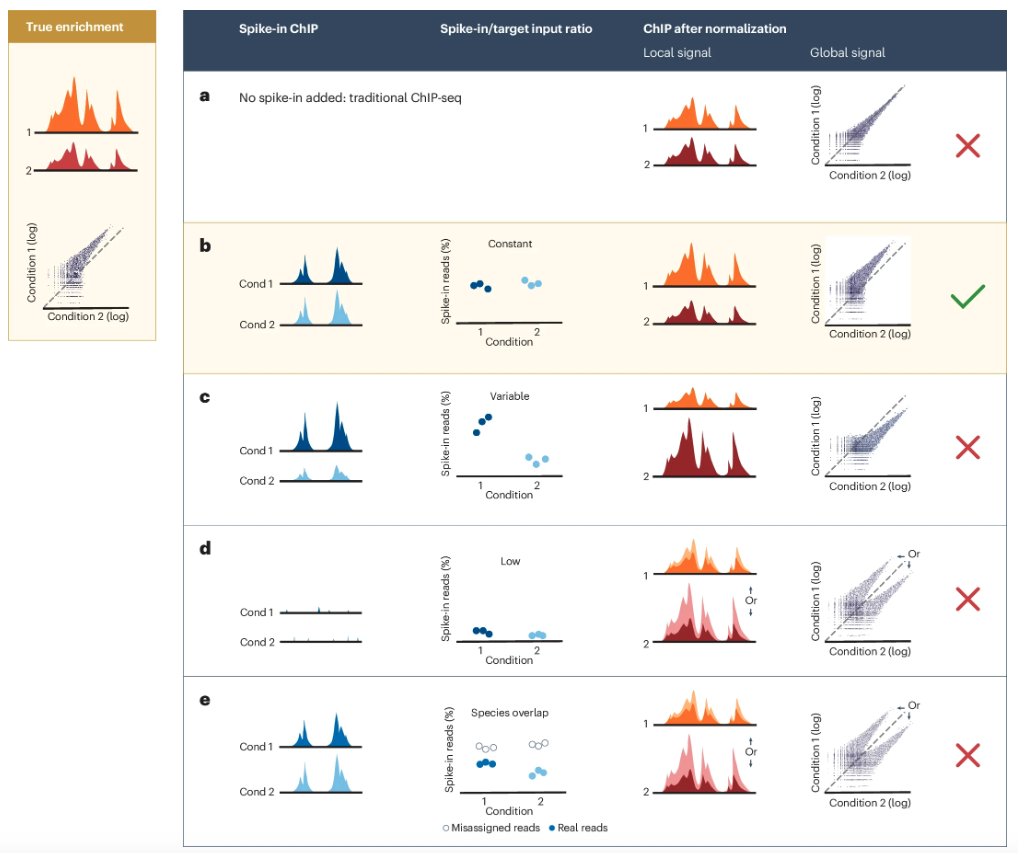

The good news is 

ChIP-wrangler provides an all-in-one wrapper function called `wrangle_all`. This function takes in fastq files and genomes used (target and spike-in) provided by the user, and provides ChIP-wrangler normalized target data, as well as a QC report. 

The general steps are as follows: 

 - **Preprocessing**: A custom genome containing the target and spike-in genomes must be created and indexed before alignment of data
 - **Trimming**: FASTQ reads are trimmed to remove library adapters and reads with low PHRED score
 - **Alignment**: Alignment is done to the prepared concatenated genome, containing all species. Alignment to all 3 species is heavily recommended, as separate alignment, especially in the case when spike-in and target species are more closely related, can result in one read aligning to multiple species and being double counted
 - **Removing of PCR duplicates**: PCR duplicates are removed (or UMIs are deduplicated if present)
 - **Isolating species-specific alignments**
 - **Estimation of IP efficiency between samples with spike-ins**: 
 - **Normalizing Target data**
 - **QC Report**: a report .html is generated visualizing nucleotide frequencies, spike-in target ratios, and other important quality checks
 - Downstream analysis, which can include:
   - **DESeq2 with ChIP-wrangler**: enabling isolation of differential peaks
   - Generating BigWigs
   - Plotting of spike-in normalized data

An in-depth explanation of each function is available in the [detailed workflow page](#Detailed-workflow).

## Installation

### Dependencies

 - HOMER
 - Samtools
 - bamUtil
 - python
 - R


The following packages are not required, but used in the tutorial and example workflow

 - fastp (or similar method of removing library adapters)
 - BWA or Bowtie2
 - UMI tools (if libraries contain umis for deduplication)
 - deeptools
 - DESeq2
 - apeglm
 - ggplot

## Schematic of Workflow

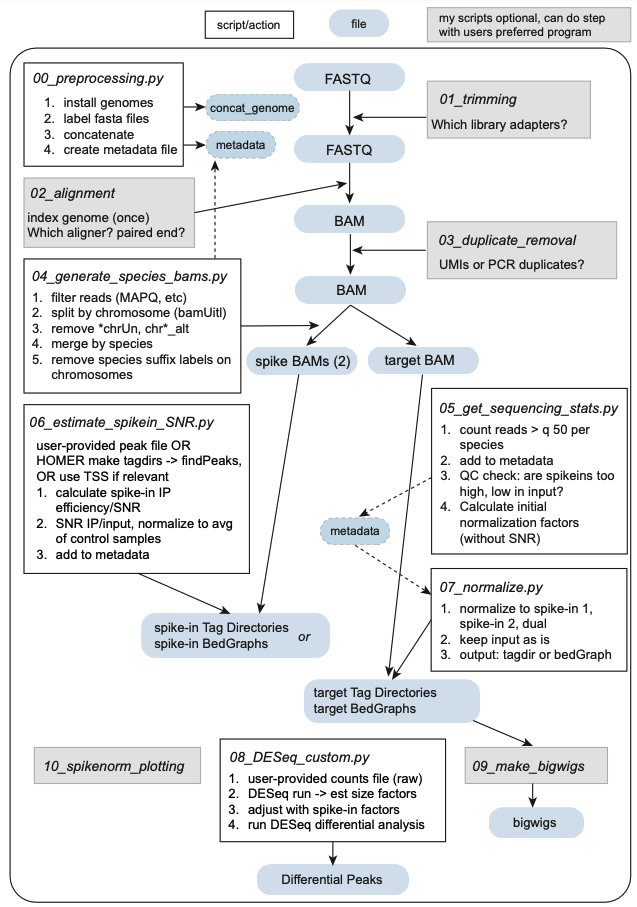

# An example ChIP-wrangler workflow start to finish

## Example dataset

We are using a dataset of H3K9ac ChIP-seq from mitotic or interphase HeLaS3 cells, each with 3 technical replicates. [Previous literature](https://pubmed.ncbi.nlm.nih.gov/30166406/) shows that multiple histone acetylation modifications decrease during mitosis, prometaphase-arrested HeLaS3 cells have a roughly 3.3-fold reduction in H3K9ac signal compared to unsynchronized/interphase cells (quantified by Mass Spectrometry).

The raw data files are named as follows: 

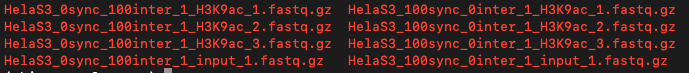

So why do we need spike-in normalization?

Below is a metagene plot of read-normalized H3K9ac data at *H. sapiens* RefSeq TSSs: 

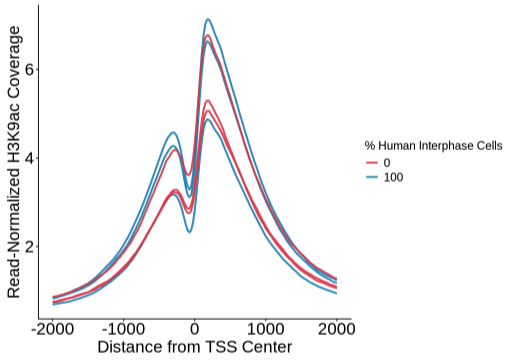

It appears that:

1) There is lots of variablity between technical replicates, and 
2) In contrast to the mass-spectrometry data, the overall amount of H3K9ac in 0% interphase cells (all mitotic-synchronized) is similar to non-synchronized cells.

After ChIP-wrangler normalization, we see the expected difference between mitotic and interphase H3K9ac levels: 

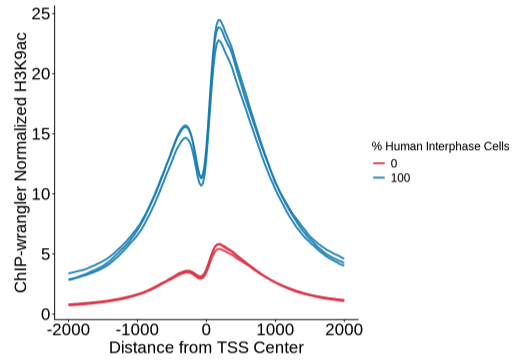

As ChIP-wrangler makes use of two spike-in species, we can plot the result after noramlizing to each species (fly and yeast) separately, and visualize the difference between the results:

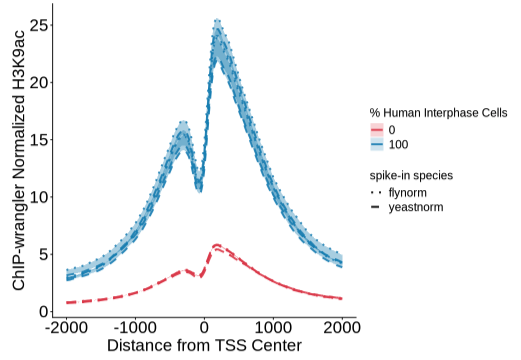

## Running `wrangle_all`

For the tutorial, we run `wrangle_all` with the following parameters: 

- target_genome = hg38
- spike1_genome = dm6
- spike2_genome = sacCer3
- single_end
- have_umis = False
- metadata = sample_metadata.tsv
- epitope_type = histone


Example: 

python run_wrangle_all.py \
    --fastq_dir ./fastqfiles \
    --genomes hg38 dm6 sacCer3 \
    --output_dir ./chip_wrangled_outputs \
    --single_end \
    --threads 8 \
    --epitope_type histone

To save computational time and allow for flexibility, there are two initial processing steps that can be skipped if the user specifies. These are the fastq trimming step and the genome-alignment step. The fastq trimming step is optional (though highly recommended as it improves alignment rates) and can be done entirely outside of ChIP-wrangler if the user desires, just place the trimmed files in a folder called `fastq_trimmed`.

The second flexible step is alignment. However, this step can only be skipped if the user has already created the custom concatenated genome (containing target and spike-in genomes) themselves, and aligned to this genome.

Steps: 

1. **Creating the custom genome yourself**: You can run `00_preprocessing`, which will preppare the genomes specified for sample alignment. If you have custom genomes that are not available through HOMER/conventional routes, instructions for how to label the genome fasta files and create your own indexed genome are also provided in the section [00_preprocessing](#00_preprocessing).
2. **Alignment**: `wrangle_all` uses BWA MEM to align to the custom genome, and can support single-end and paired-end alignments. If you wish to use a different aligner, you can generate the genome using either option in step 1, then align yourself, or modify `02_alignment_to_concatenated_genome` with your alignment parameters. The alignment files must be placed in `concat_align` for downstream processing.

To skip these steps, run: 

python run_wrangle_all.py \
    --fastq_dir ./fastqfiles \
    --genomes hg38 dm6 sacCer3 \
    --output_dir ./chip_wrangled_outputs \
    --single_end \
    --threads 8 \
    --epitope_type histone \
    --skip_trimming = True \
    --skip_alignment = True

### input samples

`wrangle_all` requires: 

1. fastq files in the `fastqfiles` folder
2. A metadata file `sample_metadata.tsv` containing the sample names

The metadata file is simply a tab-separated text file with one column named "library.ID", and filled with sample names. You can make this in excel/notepad, or, if you are in the directory containing fastq files you can generate it programatically: 

`(echo -e "library.ID"; for i in *.fastq.gz; do echo "${i%.fastq.gz}"; done) > sample_metadata.tsv`

Be mindful if you have paired end reads, etc. as there should be only one row/entry for each library.

ChIP-wrangler will perform the following steps: 
 - **Preprocessing**: If not already installed/indexed, the custom genome containing the target and spike-in genomes is created and indexed.
 - **Trimming**: FASTQ reads are trimmed to remove library adapters and reads with low PHRED score
 - **Alignment**: Alignment is done to the prepared concatenated genome with BWA MEM (paired or unpaired)
 - **Removing of PCR duplicates**: PCR duplicates are removed with samtools markdup OR umis are deduplicated with UMI_tools (if this option chosen, UMI_tools required)
 - **Isolating species-specific alignments**: bamUtil required
 - **Estimation of SNR with spike-ins**: calculated by quantifying spike-in epitope enrichment at the TSS, OR at peaks if specified
 - **Normalizing Target data**
 - **Creation of Target and Spike-in bedGraph files**

Additionally, there is the option of running `wrangle_all_analysis`, which performs downstream analysis, identifying differential peaks with DESeq2 (using ChIP-wrangler derived normalization factors)

## Expected outcomes

After running ChIP-wrangler's `wrangle_all`, the following folders will be created:

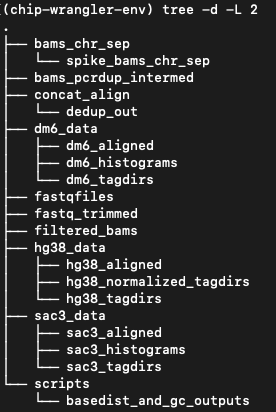

In this example, the target normalized tag directories are in `hg38_normalized_tagdirs`

# Detailed workflow

## Before running ChIP-wrangler

**Step 1. Installing/configuring genomes**

Genomes Downloaded with HOMER: hg38, dm6, sacCer3


Only needed if you have never aligned fastq files to a particular genome before (or if updating to a newer version of the genome i.e. human hg19 to human hg38). The easiest way to install a genome is with HOMER. First, check if HOMER already has the genome by asking it to list all packages:

`perl /gpfs/data01/bennerlab/path/to/homer/configureHomer.pl -list`

If you see the genome you want (Ex: hg38): then install with:

`perl /gpfs/data01/bennerlab/path/to/homer/configureHomer.pl -install hg38`

http://homer.ucsd.edu/homer/introduction/install.html

Some notes on genome names

The genomes configured with HOMER are safe for all ChIP-wrangler functions. However, custom genomes may contain characters that will interfere with downstream processes. ChIP-wrangler takes in the genome names given for spike-in species to add custom labels to the chromosome headers in the fasta files. The following names will cause problems:

- `my-genome-1`: dash is technically legal, but often used as field separator)
- `my genome` (spaces)
- `my/genome` or `my\genome` (path-breaking)
- `hg38!test` (punctuation)
- unicode characters (e.g., greek letters)
- Any genome names containing the strings "chrUn" "chr_*alt" or "chr_*random": these are also the names of unwanted contigs that are later filtered out. 

Additionally, if the custom genome name is very long it creates long header names in combined FASTAs and downstream steps which can cause problems later. 

The `00_preprocessing` step will automatically strip special characters from the genome names specified, and truncate at 20 characters, which will prevent most issues. However, the user can also add their own desired genome labels in the script directly. The below example is used for the *S. cerevisiae* genome sacCer3, where we label chromosomes with "sac3" instead of "sacCer3".

In [3]:
```{r my-chunk, eval = FALSE}
# map special genome names to shorter suffix labels
# if you desire custom genome labels, change here!
suffix_name_map = {
    "sacCer3": "sac3"
}
```

ERROR: Error in parse(text = input): attempt to use zero-length variable name


## 00_preprocessing

### Required Arguments: 

 - user_dir = User's working directory
 - genome_dir = "user_dir/genomes"
 - target_genome = "hg38"
 - spikein_genomes = `["dm6", "sacCer3"]` or `["dm6"]`

### Optional arguments: 
 - spikein_genomes_symbols = `["dm6", "sac3"]` if the user wants custom labels for downstream

### Output: 

`genomes/target_spikein1_spikein2/` folder of indexed custom genome, named with the target genome/spike-in genome names given

### General workflow:

**Step 1. Labelling spike-in chromosomes**

Next, to distinguish between chromosomes, a suffix is added to the chromosome names, for example "dm6" or "sac3" 

In this particular example I wanted to add a suffix “_dm6” to all chromosomes in the dm6 genome. Later we combine genomes into one concatenated genome, and we need a way to uniquely identify which chromosomes are from which genome.

`sed 's/>.*/&_dm6/' genome.fa > genome_dm6.fa`

We can double check by printing fastq headers
`perl -ne 'if(/^>(\S+)/){print "$1\n"}' genome_dm6.fa`

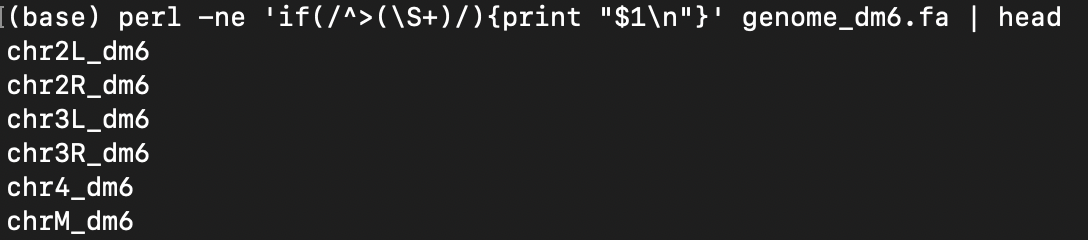

**Step 2. Create and index concatenated genome**

Concatenate all genome files:

`cat ./hg38/genome.fa ./dm6/genome_dm6.fa ./sac3/genome_sac3.fa > genome_hg38_dm6_sac3.fa`

Now we can index the genome fasta file, using the preferred aligner. For example: 

`bwa index -p genome_prefix ${file}.fa`

The first argument “genome_prefix” will the prefix of the indexed genome files created:

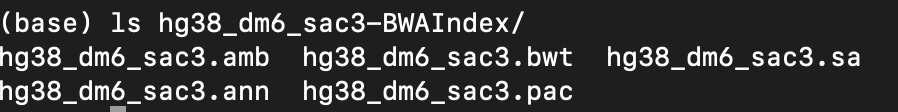

#### Sample metadata file

Samples must be named according to the following convention:

CellType_Treatment_Timepoint_BiologicalReplicate_Antibody_TechnicalReplicate

The Treatment/Timepoint columns can be used as needed, but they each are a place to put sample conditions, or categorical variables explaining the experiment. In the given example experiment, where mitotic and interphase HeLaS3 cells are combined in different ratios to create a titration of H3K9ac levels, the samples containing 100% mitotic cells are named `HelaS3_100sync_0inter_1_H3K9ac_1` while the samples containing 50% mitotic and 50% interphase cells are named `HelaS3_50sync_50inter_1_H3K9ac_1`

- Antibody (usually I have multiple IP samples from each biological sample/replicate)
- Technical Replicate (separate library preps from the same biological sample/replicate)


Other naming convention rules: 

 - No special characters besides "_" "-" or "."

The metadata file is simply a tab-separated text file with one column named "library.ID", and filled with sample names. You can make this in excel/notepad, or, if you are in the directory containing fastq files you can generate it programatically: 

`(echo -e "library.ID"; for i in *.fastq.gz; do echo "${i%.fastq.gz}"; done) > sample_metadata.tsv`


Be mindful if you have paired end reads, etc. as there should be only one row/entry for each library.

## 01_trimming_fastqs

### Required Arguments

 - user_dir: working directory, from which fastq files are found
 - paired_end or single_end

### Optional Arguments

 - threads
 - desired PHRED score cutoff (default: 20 in a 4bp window)

### Output: 

 - trimmed fastq files in `user_dir/fastq_trimmed/*.trim.fastq.gz`
 - log files in `user_dir/fastq_trimmed/*.trim.log`

Recommended settings for single end data: 

`trimmomatic SE ../fastqfiles/${base}.fastq.gz ${dir}/trimmed_fastq/${base}.trim.fastq.gz -threads 8 ILLUMINACLIP:/home/lahodge/miniconda3/pkgs/trimmomatic-0.39-hdfd78af_2/share/trimmomatic-0.39-2/adapters/TruSeq3-SE.fa:2:30:7 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:20 MINLEN:36`

Recommended settings for paired end data

`trimmomatic PE -threads 12 ../fastqfiles/${base}_R1_001.fastq.gz ../fastqfiles/${base}_R2_001.fastq.gz ${base}_R1.trimmed.fastq ${base}_R1.un.trimmed.fastq ${base}_R2.trimmed.fastq ${base}_R2.un.trimmed.fastq ILLUMINACLIP:/path/to/trimmomatic-0.39-hdfd78af_2/share/trimmomatic-0.39-2/adapters/TruSeq3-SE.fa:2:30:7 SLIDINGWINDOW:4:20`

## 02_alignment_to_concatenated_genome

### Required arguments: 

- paired-end or single end

### Optional arguments: 

- threads
- seed length (for short reads)

### Outputs

- Aligned files: `concat_align/*.sam`
- BWA MEM log files: `concat_align/*.log`

Recommended BWA MEM settings for single end data: 

`bwa mem -t 16 ~/data/concat_genome-BWAIndex/concat_genome "$r1" > ../concat_align/${base}.concat.sam 2> ${base}.log.txt`

Recommended BWA MEM settings for paired-end data, with short reads (< 20 on at least one mate in a pair):

`bwa mem -t 16 -k 12 ~/data/concat_genome-BWAIndex/concat_genome "$r1" "$r2" > ../concat_align/${base}.concat.sam 2> ${base}.log.txt`

## 03_remove_pcr_duplicates

It's recommended to use unique molecular identifiers (UMIs) when generating libraries, so that duplicate reads can be removed. If no UMIs are present, removing PCR duplicates is still recommended, and PCR duplicates are estimated by the 5' end of each single-end read (see Samtools manual).

ChIP-wrangler contains functions for removing duplicates from single-end and paired-end reads (`03_remove_pcr_duplicates.py`), as well as UMI deduplication (`03_umi_dedup.py`) which relies on `UMI_tools`. UMIs must be present in the header of the bam file (if present in the FASTQ header, they will automatically be included in the bam file).

### UMI deduplication

Below is an example of Read 1 of a fastq file, with UMIs in the read header:

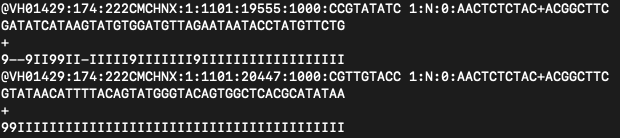

CCGTATATC (at the end of the header line) is the UMI sequence, and AACTCTCTAC+ACGGCTTC are the dual-barcoded indices which identify all reads in this library.

With UMIs in the read header:

`umi_tools dedup --stdin=../bams_pcrdup_intermed/${base}.sorted.bam --stdout=dedup_out/${base}.dedup.new.unique.bam --extract-umi-method=read_id --umi-separator=":" --method=unique --log=dedup_out/${base}.log --output-stats=dedup_out/${base}`

## 04_generate_species_bams

### Required arguments: 

- user_dir = User's working directory
- spike_species_1 = default "dm6"
- spike_species_2 = default "sac3"
- target_species = default "hg38"

### Optional arguments:
- mapq_threshold = default 50
- max_threads = default 4

### Output files:
- filtered bam files: `filtered_bams`
- individual chromosome bam files are in `bams_chr_sep` they can be removed when finished
- species-specific bam files: `spike1_species_data/spike1_species_aligned/`, `spike2_species_data/spike2_species_aligned/`, `target_species_data/target_species_aligned/`
- log files: counts per individual chromosome are automatically written to stdout by bamUtil splitChromosome, these are stored in log files ending in ".splitting.log" inside `bams_chr_sep`

Usage:

python generate_species_bams.py \
    --user_dir /home/user/project \
    --spike1 dm6 \
    --spike2 sac3 \
    --target hg38 \

With one spike-in species: 

python generate_species_bams.py \
    --user_dir /home/user/project \
    --spike1 dm6 \
    --spike2 none \
    --target hg38

With optional arguments:

python generate_species_bams.py \
    --user_dir /home/user/project \
    --spike1 dm6 \
    --spike2 sac3 \
    --target hg38 \
    --threads 12 \
    --mapq 50

### General workflow: 

**Step 1: Filtering**

Remove reads with MAPQ before the specified threshold, and if there are paired end reads, remove pairs if each mate maps to a different chromosome

**Step 2: Split BAMs by chromosome**

Using bamUtil, we split the bam file into individual bam files for each chromosome, which are placed into the folder bams_chr_sep. We then remove alternate chromosomes (chr*_alt), chrUn, etc.

**Step 3: Merge BAMs by chromosome**

Bam files containing the appropriate chromosome for each species (in this example: _dm6 and _sac3) are merged to create one bam file per species, per sample. 

**Step 4: Cleanup chromosome names**

When we first created our concatenated genome, we gave the chromosomes from the spike-in genome suffixes to distinguish them from target chromosomes. Therefore, our resulting alignment files contain chromosome names with the same suffixes in column 3 of the bam file (see below for an example). We need to remove these before we try to make HOMER Tag Directories, BigWigs, or any other filetype that depends on genomic position information.

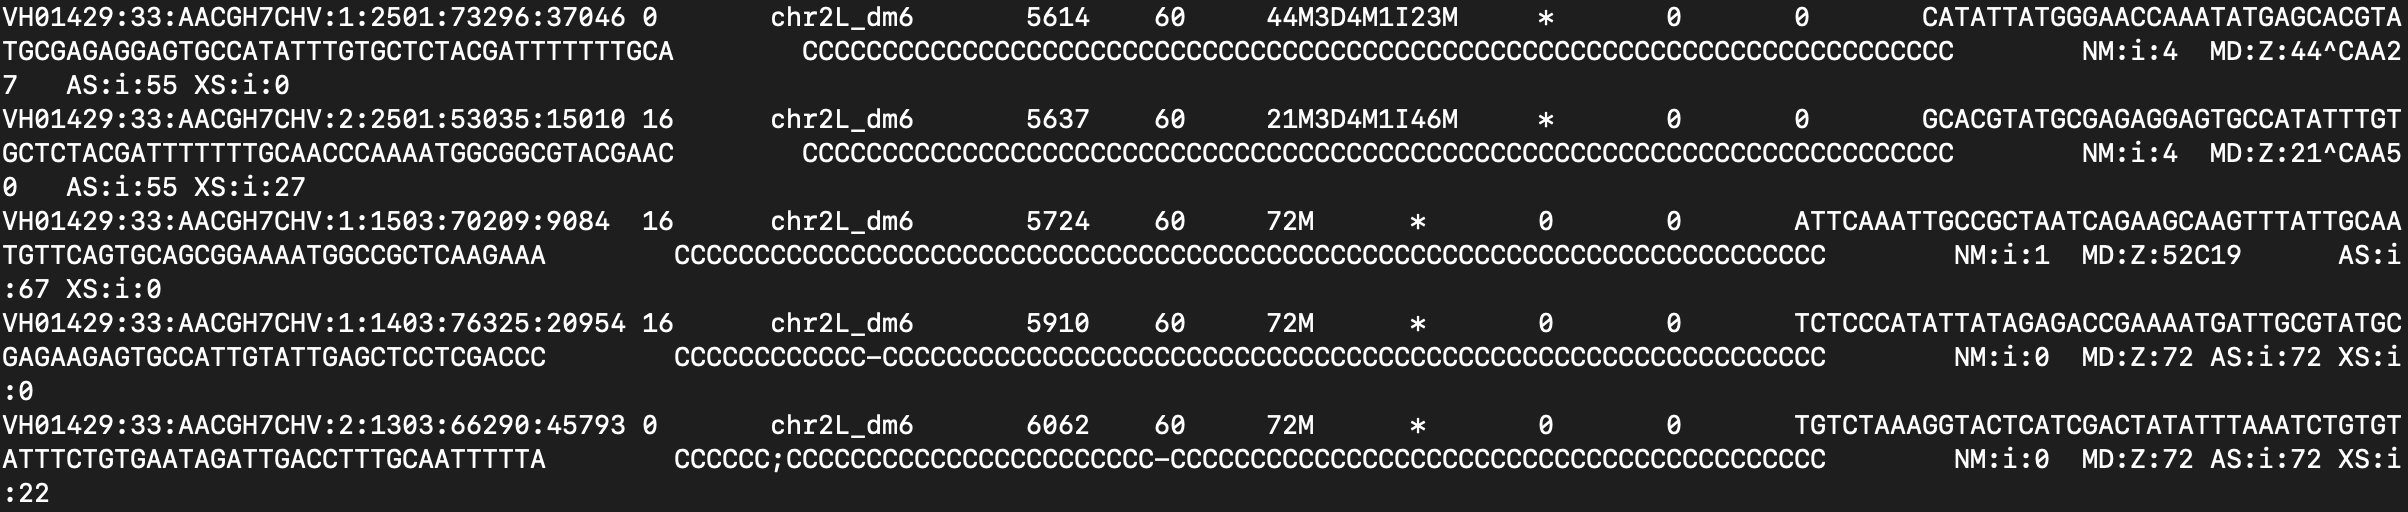

We remove the suffixes from the chromosome names of both spike-in speices, and output .sam files, labeled ".nosuffx2.sam" in the following directories: 

`../dm6_data/dm6_aligned/`

`../sac3_data/sac3_aligned/`

`../hg38_data/hg38_aligned/`



## 05_get_sequencing_stats

### Inputs

- species-specific alignment files
- metadata file

### Required Arguments:

- user_dir = Users working directory

### Optional Arguments:

- 

### Output Files:

 - target_dir = "../hg38_data/hg38_aligned"
 - dm6_dir = "../dm6_data/dm6_aligned"
 - sac3_dir = "../sac3_data/sac3_aligned"

Usage: 

python 05_get_sequencing_stats.py \
    --user_dir /proj/experiment1 \
    --target_species hg38 \
    --spike1_species dm6 \
    --spike2_species sac3

### General Workflow

**Step 1: Generating alignment summary**

First, we use samtools to count reads above our MAPQ threshold for each species, and report the results in columns named: 

- "hg38_reads": counts aligned to the target genome
- "dm6_reads": counts aligned to the first spike-in genome
- "sac3_reads": counts aligned to the second spike-in genome

We then calculate the ratio of each spike-in species reads to target reads: 

- "dm6/hg38"
- "sac3/hg38"

**Step 2: QC checks**

If the spike-in/target ratio is too low in the input samples, it could be a sign that too litte spike-in material was added, and the normalization factors are likely to be noisier. This is especially crucial in the input library, which is used to assess potential GC bias, and quantify the amount of chromatin from each species present in the IP reaction. However, too much spike-in material can also affect normalization accuracy as demonstrated [here](https://www.nature.com/articles/s41587-024-02377-y).

Below shows the impact of varying the amount of spike-in species' chromatin on normalization of target data. HeLa-S3 cells were treated with TSA, a pan-HDAC inhibitor expected to globally increase histone acetylation levels, including H3K9ac. As the spike-in/target ratio becomes too high, there is no observable difference in treatment compared to control:

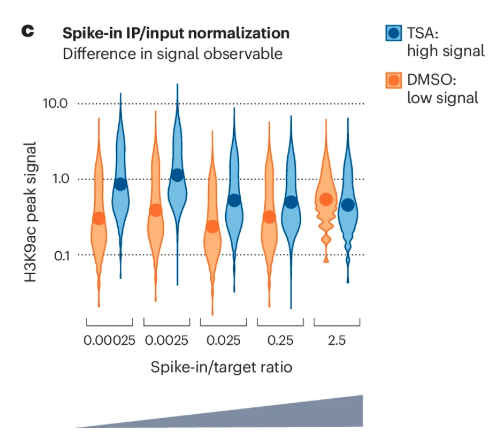

Sufficient spike-in/target ratios depend on multiple factors: 

- Size of the spike-in genome: a larger genome will need more reads for equal genome coverage
- Total read depth
- Epitope being used in IP: active histone modifications such as H3K27ac tend to be abundant in the small, gene-dense *S. cerevisiae* genome, meaning a lower amount of spike-in material is needed in the input to generate sufficient coverage in the IP. However, sufficient read-depth is still cruicial in the input library to accurately quantify the amount of starting chromatin

For best results, a titration of spike-in material will provide a good indication of successful spike-in ratios. Here, we flag ratios of spike-in/target below 0.001 (< 20000 reads out of 20M) or above 0.25 (> 5M reads out of 20M) in the input libraries.

**Step 3: Calculating Initial Normalization Factors**

The basic normalization factor is calculated by quantifying the ratio of spike-in/target reads in the IP relative to it's corresponding input: 

 - dm6 IP/input = (dm6 IP reads)/(hg38 IP reads) / (dm6 input reads/hg38 input reads)
 - sac3 IP/input = (sac3 IP reads)/(hg38 IP reads) / (sac3 input reads/hg38 input reads)

The intuition behind this normalization: the spike-in IP/input gives an idea of the *enrichment* of the spike-in library relative to the target. As total target epitope increases or decreases, we imagine the spike-in *enrichment* will respond inversely.

From our mitotic and interphase titration example we can see this visually when plotting the relative amounts of reads per species in each condition. 

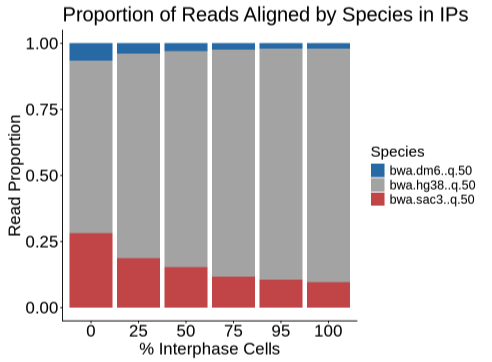

Factors such as genome size, relative abundance of epitope, and differential antibody affinity between species can significantly alter the yielded reads in the IP from a given amount of input chromatin. 

For example, take the condition from the plot above with all unsychonized, interphase HeLaS3 cells. Below we plot the relative reads per species in three technical replicates of H3K9ac ChIP-seq and their corresponding input library.

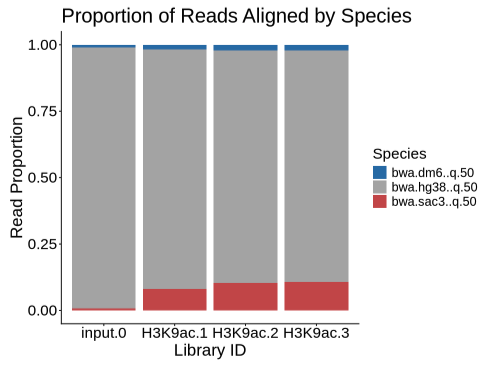

In the input library, *H. sapiens* takes up the vast majority of reads (~98%). However, in the IP libraries, only ~67% of reads align to *H. sapiens*. Here, the ratio of *D. melanogaster*/*H.sapiens* reads in a H3K9ac IP library are roughly 2.5-fold the ratio of *D. melanogaster*/*H.sapiens* in their corresponding input library, meaning the value of dm6 IP/input for this sample is 2.5. Meanwhile, the ratio of *S. cerevisiae*/*H. sapiens* in the same H3K9ac IP sample is around 15-fold that of the input ratio.

Below, we plot the IP/input-derived normalization factors from each spike-in species:

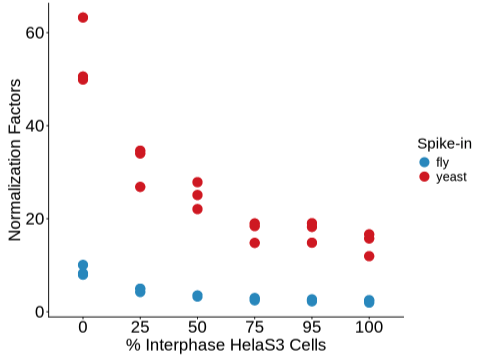

These normalization factors must be adjusted to be in the same range before they can be averaged to create the dual spike-in normalization factor.

We do this by "average-control normalization": for each spike-in species, we divide each normalization factor by the average normalization factor in the control conditions. Here we set the mitotic HeLaS3 cells (with minimum H3K9ac) as the control condition.

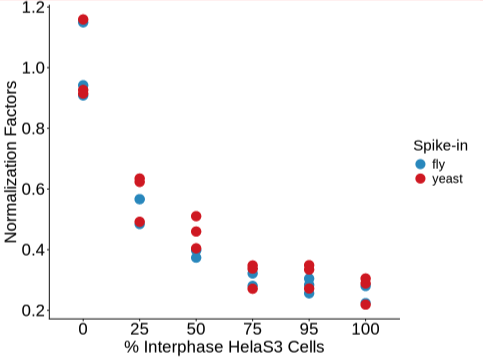

One QC for healthy spike-in normalization is that the results should be "species-agnostic"- that is, the normalization factors generated for each spike-in species should be similar. Below shows an example of well-correlated spike-in normalization factors for the mitotic H3K9ac titration dataset:

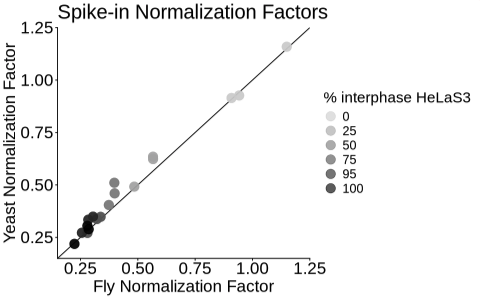

Spike-in normalization *can* be performed with these normalization factors, however it is highly recommended to adjust for ChIP-seq IP efficiency, using the spike-in samples to estimate the signal-to-noise ratio in each library. In the next section is an example where IP efficiency varies greatly between sample conditions, and must be accounted for to have proper normalization.

## 06_estimate_spikein_ipeff

### Configurable variables

 - spike_alignments = locations of spike-in alignment files: default locations `../dm6_data/dm6_aligned/` and `../sac3_data/sac3_aligned/`
 - genome_region = genome location for estimating IP efficiency: default TSS

### inputs

 - alignment files for each spike-in species
 - metadata file

### General workflow

Below is an example of the impact on spike-in normalization, when target epitope levels change dramatically. Here, HeLaS3 cells were treated with 1uM TSA for 18 hours, after which levels of H3K27ac significantly increased:

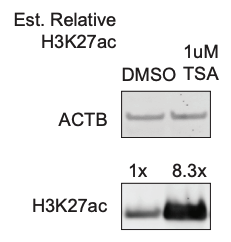

Cells with TSA were mixed with untreated cells to create a titration of H3K27ac levels from low to high: 

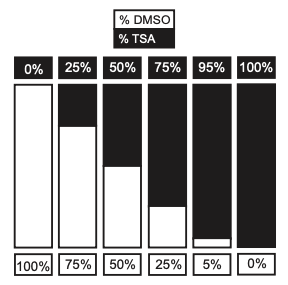

Across conditions, as each sample contained a larger proportion of TSA-treated cells, the amount of H3K27ac recovered for spike-ins *D. melanogaster* and *S. cerevisiae* was decreased:

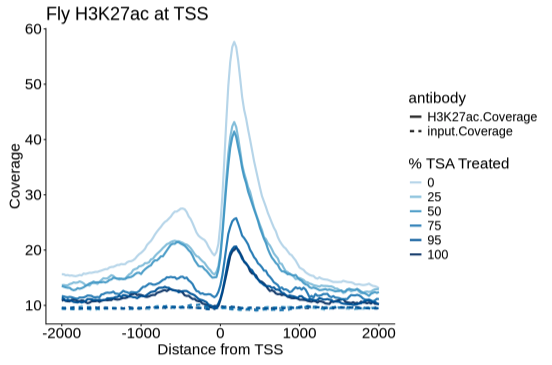
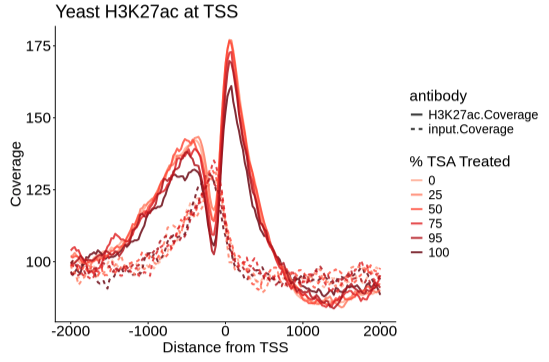

We quantify signal at the TSS by calculating the area under the curve of the coverage histogram:

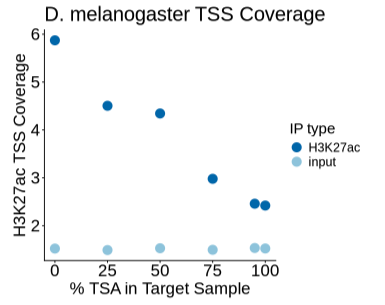
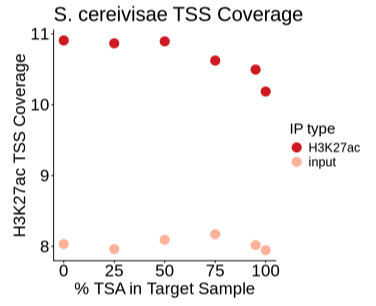


We use the TSS Coverage in the input sample to estimate background signal, subtracting from the H3K27ac coverage, to estimate the IP efficiency in each spike-in sample. 

*Note*: If the target epitope is not an active histone mark, IP signal can be quantified at peak regions, or other epitope-relevant genomic regions (for example, gene bodies for H3K36me3). 

Below is a comparison of H3K27ac signal quantified at TSSs or Peak Regions in *D. melanogaster*

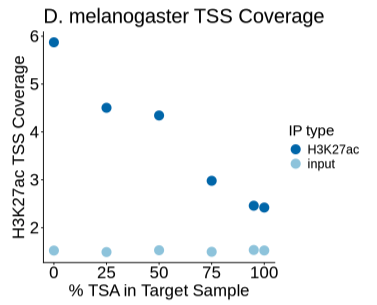
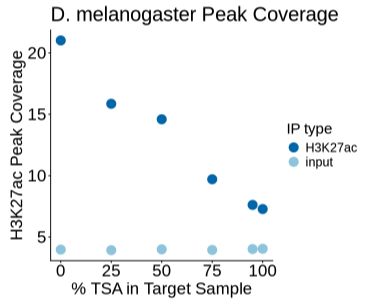

After subtracking out the background signal, we are left with IP signal for each spike-in

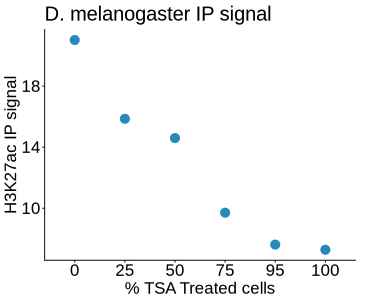
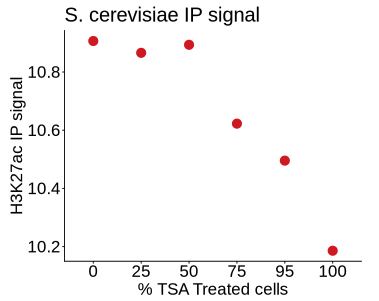

Note the difference in range of the y axes between *D. melanogaster* and *S. cerevisiae*: as can also be seen from the TSS plots, *S. cerevisiae* H3K27ac signal is relatively constant across increasing levels of *H. sapiens* H3K27ac signal.

We can then combine the SNR signal with the IP/input-derived normalization factor, to arrive at IP-efficiency-adjusted Spike-in Normalization Factors:

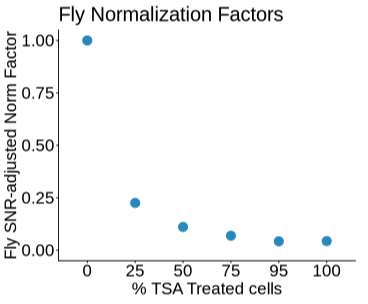
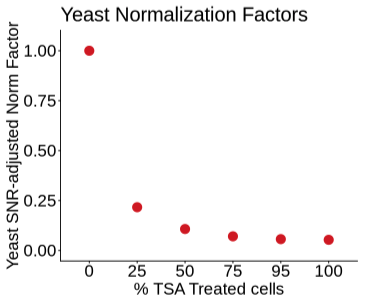

Below are plots comparing the fly- and yeast-derived normalization factors, before and after the adjustment for IP efficiency. You will notice the in the plot on the left the normalization factors do not agree as well. Here, the normalization factor has not taken into account the varying IP efficiencies between samples. 

The resulting spike-in normalization factors, after accounting for IP efficiency, correlate between species: 

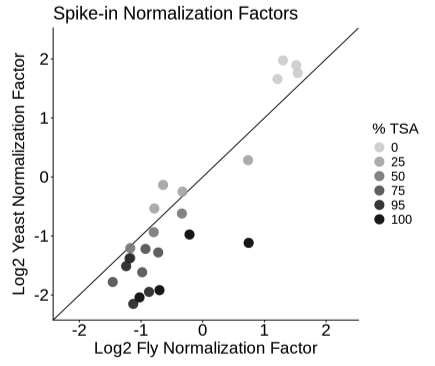
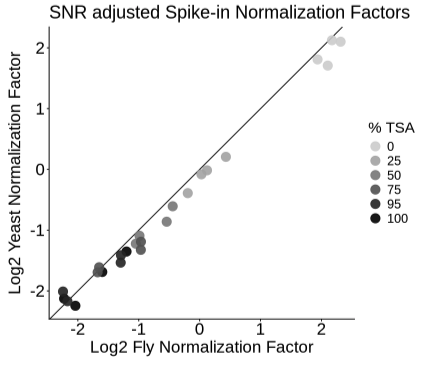


In cases where target epitope changes less, there is less of an impact on spike-in IP efficiency. Therefore, the adjustment has less of an effect on the normalization factors. From our mitotic and interphase H3K9ac titration example, below are the *D. melanogaster* and *S. cerevisiae* metagene plots at TSSs:

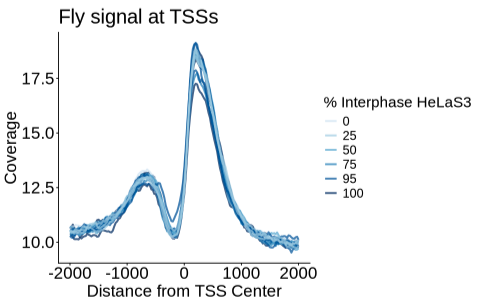
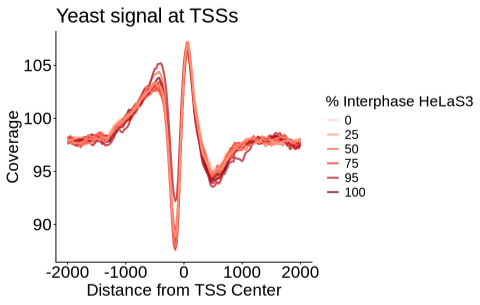

As expected, the resulting normalization factors are similar before and after adjusting for IP efficiency: 

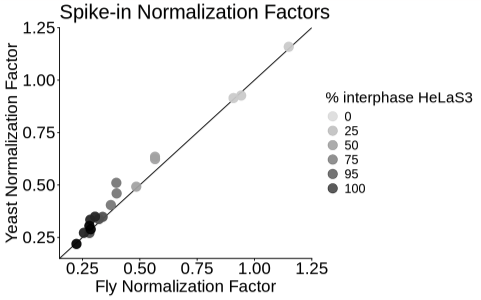
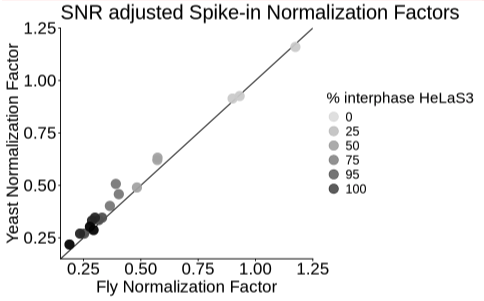


## 07_normalize

### Configurable variables

- base_dir = "./hg38_tagdirs"  # adjust if needed
- output_dir = "./hg38_normalized_tagdirs"
- suffix_to_remove = The end of the filename with processing details, not matching the metadata sheet (Default ".hg38-tagdir")
- normfactor_adjust_method = Adjustment for normalization factors (Default: "mean_control", other option: "mean_all")
- output_filetype = Tag Directories or bedGraph files (if --bedGraph option chosen, `deeptools` must be installed)

### inputs

- metadata.tsv containing columns: `library.ID`, `IP`, `dm6.normfactor.ipeff.adj`, `sac3.normfactor.ipeff.adj`
- target bam file

### General workflow

- First, target alignment files from `../target_data/target_aligned/` are converted into HOMER Tag Directories, placed in `../target_data/target_tagdirs/`
- Then, the `tagInfo.txt` file is modified, adjusting the Total Tags variable by the spike-in normalization factors
- The resulting spike-in normalized tag directories are placed in `../target_data/target_normalized_tagdirs` and named by the normalization method
  - In our example, this would be "fly.normalized.tagdir", "yeast.normalized.tagdir" or "normalized.tagdir"
- Differences between each spike-in normalization factors are stored in `sample_metadata.tsv`, it's recommended to check how similar they are (10_make_QC_report will also generate a plot of the normalization factor correlation among other things). If the normalization factors are sufficiently similar, the user can simply proceed with the dual normalized data "normalized.tagdir" for downstream quantification. If desired, the results after normalizing to each individual spike-in species can be plotted, or tag directories can be converted to bigwigs/etc. for visualization.

## 08_QC_data

This function creates datasets for plotting in R: 

- checks for presence of spike-in TSS histograms, makes if not present
- aggregates nucleotide frequency data from each species for each input library
- aggregates total GC content data from each species for each input library

After running, the following new datasets are available in `qc_outputs`: 

all_gc_stats_combined.tsv  
dm6_gc_stats.tsv   
hg38_gc_stats.tsv  
sac3_gc_stats.tsv
dm6_basedist.tsv           
hg38_basedist.tsv  
sac3_basedist.tsv

## 09_make_QC_report

The final QC report includes:

- Status of spike-in/target input ratios
  - Ratios too low (< 0.001 spike-in/target), too high (> 0.25 spike-in/target), or too variable within the same experiment (>10-fold variation) are flagged
  - Plots spike-in/target ratios for each experiment set
- Spike-in IP histogram plots (default: at TSSs)
- Estimated GC content in input libraries from each species
- Correlation of spike-in normalization factors

## 10_DESeq2_with_ChIP-wrangler



### Configurable variables 

- adj pvalue cutoff: default padj = 0.05
- Log2FC cutoff: default Log2FC = 1 (2 fold change)
- shrinkage method: default apeglm as recommended by DESeq2

### inputs

- raw counts file at shared peaks
- metadata sheet containing column: dual.normfactor.ipeff.adj 

### General Workflow

**Step 1. Create the DESeq counts matrix**

First, we need to create a DESeq formatted counts matrix, where every column is a sample, and every row is a peak/region.

When creating the counts matrix

- We move the chromosome name, and start/end positions of each peak to row names in the count matrix, this will make it easier to identify differential peaks later
- We check all sample columns contain raw counts (i.e. whole numbers only). Sometimes, if the data is paired end, the raw counts can be reported in increments of 0.5, we round these counts

**Step 2. Create coldata (metadata) for DESeq**

Based on the same raw counts matrix provided earlier, we create a metadata sheet 

*Very Important Note* from https://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#standard-workflow: 

"It is absolutely critical that the columns of the count matrix and the rows of the coldata (information about samples) are in the same order. DESeq2 will not make guesses as to which column of the count matrix belongs to which row of the column data, these must be provided to DESeq2 already in consistent order." 

Therefore, we need to check that colnames of cts match row names of coldata!!
This NEEDS to return TRUE before we proceed!

`all(rownames(coldata_experiment) == colnames(cts_experiment))`

**Step 3. Create DESeq object**

Use `DESeqDataSetFromMatrix(countData = cts_experiment, colData = coldata_experiment, design = ~ batch + condition)` to create a DESeq dataset object from a raw counts matrix.

`DESeqDataSetFromMatrix` converts the counts matrix to an S4 object. Here the choice of design is important:

`design = ~ repgroup + treatment * timepoint`
- repgroup models the replicate sets (keeps 1&2 vs 3&4 separate as a blocking factor).
- treatment * timepoint gives main effects and the interaction (so we can test treatment effects at particular timepoints or time effects within treatments).
- this is best if we want to test difference mostly between treatments
- Problem: this only works if we have *every timepoint and treatment combination*; otherwise, deseq2 cannot estimate the interaction of treatment and timepoint

`design = ~ repgroup + timepoint`
- this compares effects at each timepoint, ignoring the different treatments
- In `results()` comparisons:
    - We will only be able to test different treatments averaged across timepoints.
    - Any timepoint-specific differences will be "absorbed into the noise" (or confounded with treatment effect, depending on balance)

Solution: we make a new group variable combining treatments and timepoints

**Step 4. Run DESeq to generate default size factors**

`dds <- DESeqDataSetFromMatrix(countData = cts_experiment, colData = coldata_experiment, design = ~ biorep + condition)`
`dds <- DESeq(dds)`

You will see the following output: 

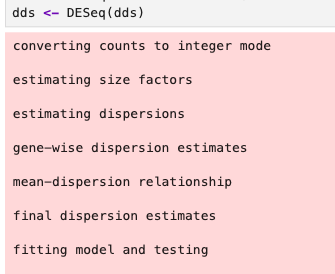

**Step 5. Initial QC checks**

Dispersion Estimates: with `summary(mcols(dds)$dispersion)`

Log2 fold shrinkage on read-normalized data: 

`resNorm <- lfcShrink(dds, coef="condition_treat_vs_control", type="apeglm")`

Optional: can plot the default, read-normalized output of DESeq2, comparing adjusted p-value and log2fc in a volcano plot

**Step 6. Generate Custom Size Factors**

We import our metadata, multiply the DESeq size factors with our custom size factors, and assign them to our DESeq object.

**Step 7. Run DESeq2 with Custom Size Factors**

Now when you run DESeq2, you will see the custom size factors being used: 

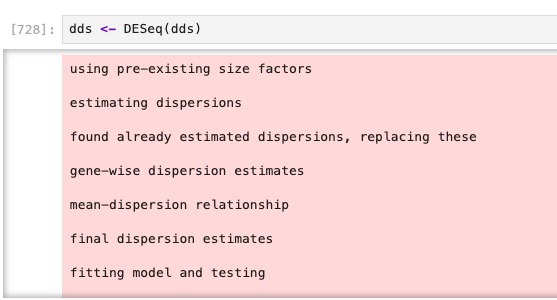


### Plot PCA without batch effects

`mat <- assay(vsd)`

- vsd is a DESeqTransform object created by vst(dds, blind=FALSE).
- assay(vsd) returns the matrix of transformed counts (rows = genes/peaks, columns = samples).
- This matrix is already variance-stabilized (VST), so it’s appropriate for PCA, clustering, heatmaps, etc.
- We assign it to mat so we can manipulate it

`mat_corrected <- limma::removeBatchEffect(mat, batch=dds$repgroup)`

- `removeBatchEffect()` treats each row (gene/peak) as a separate linear model and subtracts the estimated batch effect.
- `batch = dds$repgroup` tells limma which variable is the batch (here, rep12 vs rep34).
- Result: a new matrix `mat_corrected` where variation due to repgroup is removed, but other variation (e.g., condition differences) remains.
- This is purely for visualization, it doesn’t change DESeq2’s statistical model or results.

`vsd_corrected <- vsd`

- vsd contains more than just the matrix: it has `colData` (sample metadata), rownames, metadata, class info (DESeqTransform), etc.
- We copy it so we can replace the assay without losing all the structure.
- Important: this preserves `colData`, which plotPCA() uses to color/group samples

`assay(vsd_corrected) <- mat_corrected`

- `assay(vsd_corrected)` normally points to the VST matrix.
- By assigning `mat_corrected` here, we swap in the batch-corrected values.
- The DESeqTransform object still carries all metadata, rownames, etc., but now the PCA will use the batch-corrected values.



### Visualization and QC checks after Custom DESeq

#### Dispersion estimates

plotDispEsts(dds)

summary(mcols(dds)$dispersion)

`resNorm <- lfcShrink(dds, coef="condition_treatment_vs_control", type="apeglm")`

`summary(res_shr$log2FoldChange, na.rm=TRUE)`

`summary(res_mle$log2FoldChange, na.rm=TRUE)`

Plot of log2 fold changes before and after shrinkage: points under the line shrink towards 0

`plot(res_mle$log2FoldChange, res_shr$log2FoldChange, pch=20, cex=0.5, xlab="MLE log2FC", ylab="apeglm shrunken log2FC")
abline(a=0,b=1,col="red") `

#### MA plots before/after shrinkage:

`DESeq2::plotMA(res_mle, ylim=c(-3,3), main="MA (MLE)")`

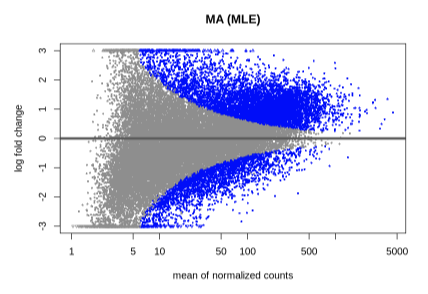

`DESeq2::plotMA(res_shr, ylim=c(-3,3), main="MA (apeglm shrunken)")`

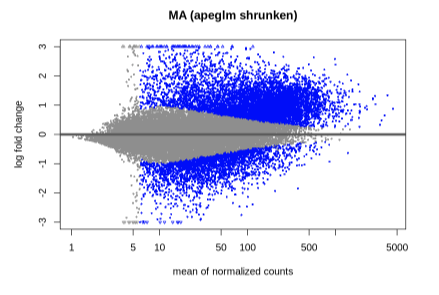


#### Rlog counts: 

rlog_counts_HCT_K27ac <- assay(vsd)

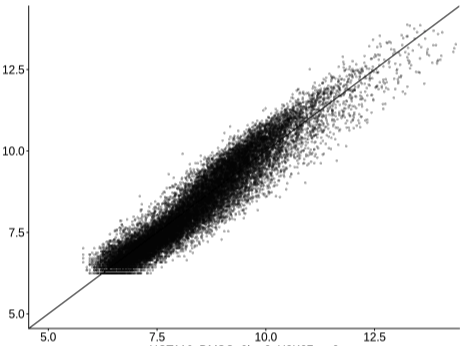


#### Volcano plot

#### top up/down regions

Because we moved the peak positions to the row names before creating the DESeq object, we can quickly check which peaks have the most significant changes: 

`top_peak_id <- rownames(res)[which.min(res$padj)]`